In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Time, s', size=14)
    plt.xticks(size=14)
    plt.ylabel('Magnitude', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

615


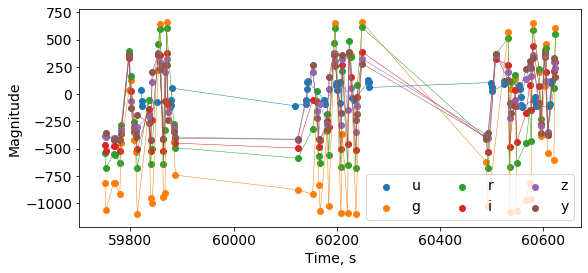

34299


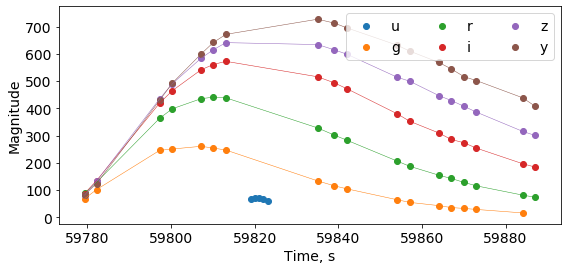

70046


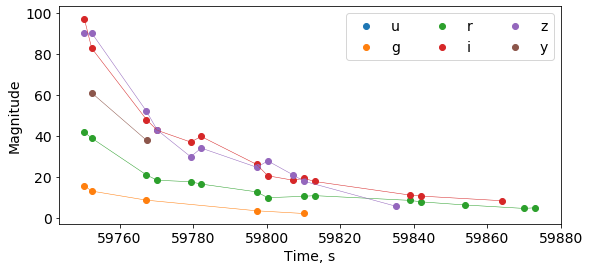

102036


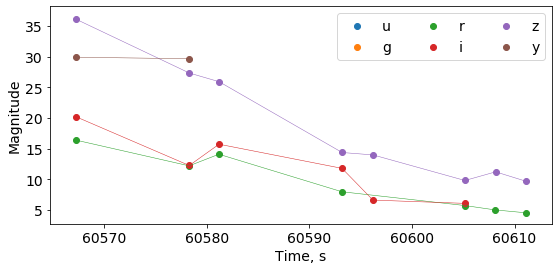

131629


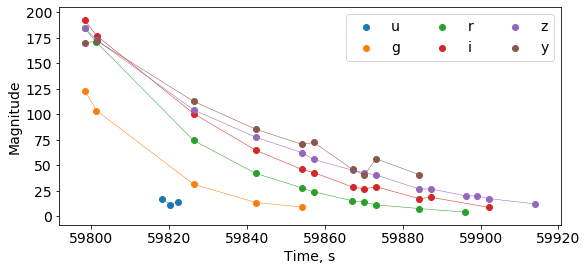

169315


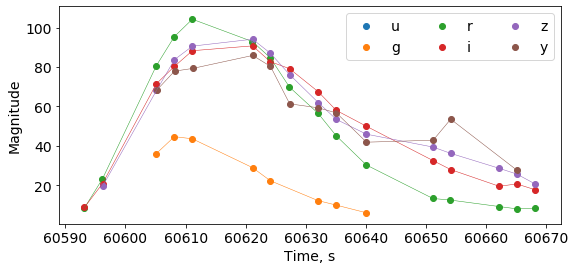

199547


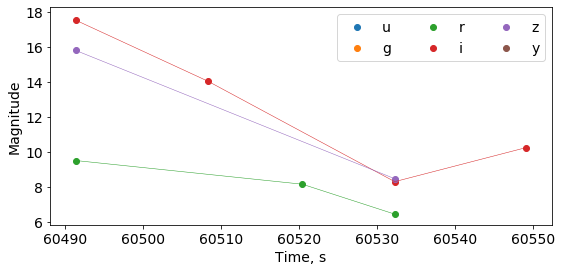

229855


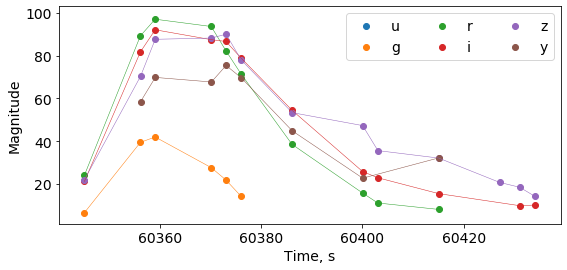

258489


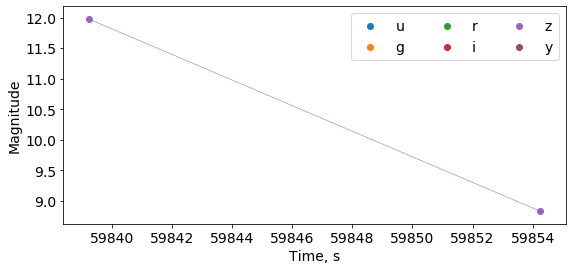

290682


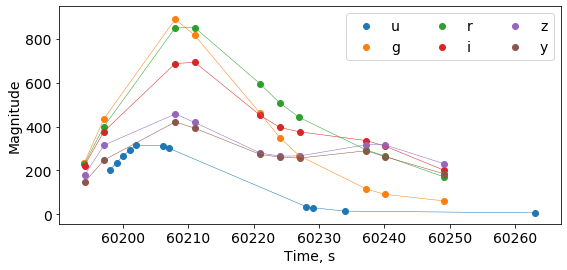

In [13]:
for i in object_ids[::200][:10]:
    print(i)
    anobject = get_object(data, i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

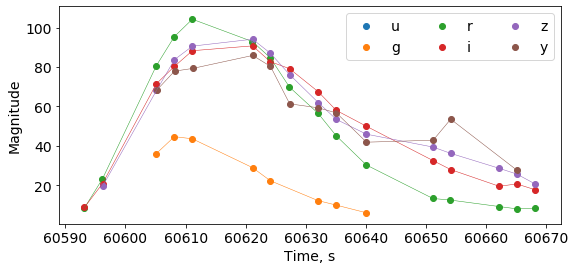

In [14]:
anobject = get_object(data, 169315)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)

In [15]:
MODEL = "GP"

In [16]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a regression model to approximate light curves
if MODEL == "XGB":
    from xgboost import XGBRegressor
    reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
elif MODEL == "NN":
    reg = regressor.FitNNRegressor(n_hidden=100, n_epochs=100, batch_size=1, lr=0.01, lam=0.01, optimizer='Adam')
elif MODEL == "GP":
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
    kernel = C(1.0) * RBF(1.0) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = reg.predict(X_test_ss)

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
anobject_train_pred['flux'] = reg.predict(X_train_ss)

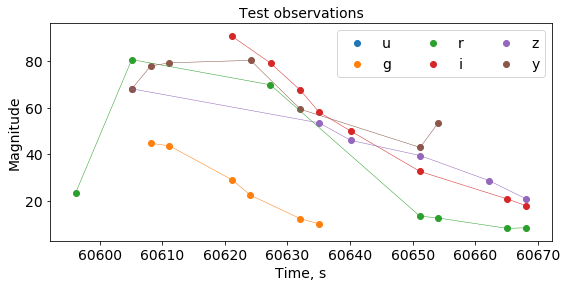

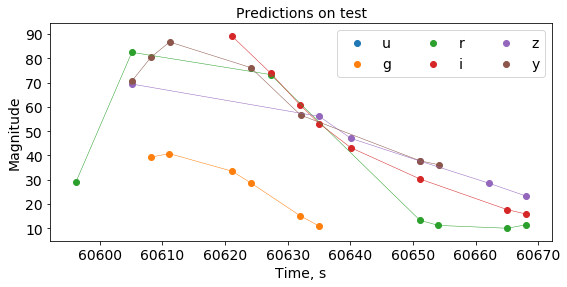

In [17]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

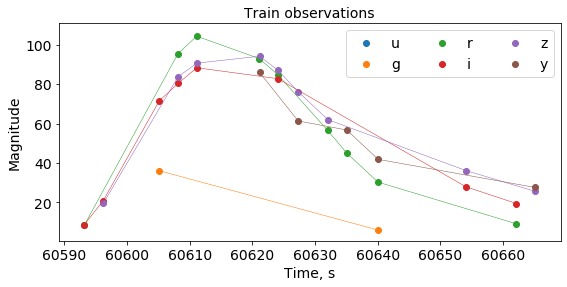

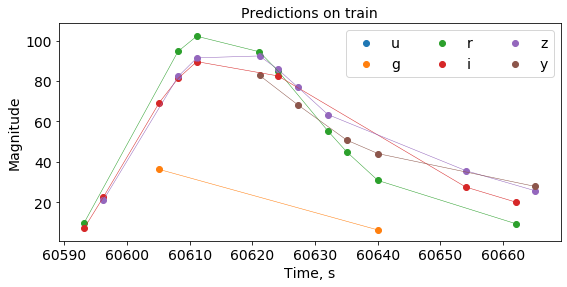

In [18]:
plot_light_curves(anobject_train, "Train observations")
plot_light_curves(anobject_train_pred, "Predictions on train")

In [19]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  4.768267744304941
MAE:  3.6511043132768517
RSE:  0.18976122429972656
RAE:  0.16742611793023848
MAPE:  10.899447820170789


# Test on many objects

In [20]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids[::100]:
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if len(anobject) < 10: continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "XGB":
        from xgboost import XGBRegressor
        reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    elif MODEL == "NN":
        reg = regressor.FitNNRegressor(n_hidden=100, n_epochs=100, batch_size=1, lr=0.01, lam=0.01, optimizer='Adam')
    elif MODEL == "GP":
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
        kernel = C(1.0) * RBF(1.0) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = reg.predict(X_test_ss)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + list(metrics)
    

Object  615  with  333  observations
Object  34299  with  94  observations
Object  53354  with  23  observations
Object  70046  with  47  observations
Object  84716  with  57  observations
Object  102036  with  23  observations
Object  131629  with  56  observations
Object  152300  with  26  observations
Object  169315  with  67  observations
Object  186115  with  347  observations
Object  229855  with  49  observations
Object  243726  with  11  observations
Object  274938  with  245  observations
Object  290682  with  61  observations
Object  309058  with  77  observations
Object  340017  with  32  observations
Object  3166910  with  16  observations
Object  5105896  with  12  observations
Object  13850906  with  80  observations
Object  24271581  with  107  observations
Object  26714405  with  95  observations
Object  34052183  with  12  observations
Object  36348779  with  12  observations
Object  40882197  with  26  observations
Object  43018203  with  12  observations
Object  4541

In [21]:
np.round(report.mean(), 2)

ID      43809805.39
RMSE         596.57
MAE          494.67
RSE            0.77
RAE            0.72
MAPE          81.88
dtype: float64

In [22]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,615,363.041,298.884,0.980062,0.974751,119.183
1,34299,8.48162,6.40469,0.0428105,0.0365744,5.90959
2,53354,20.7174,10.8024,1.14215,0.782778,47.8861
3,70046,10.6549,7.42907,0.409808,0.365237,30.8607
4,84716,13.4929,8.4677,0.346777,0.255312,23.5232
5,102036,3.62421,2.55148,0.383754,0.310124,12.6397
6,131629,5.53351,4.01768,0.0949953,0.0864675,8.05803
7,152300,4.47695,3.66244,0.328145,0.305952,14.3619
8,169315,4.76827,3.6511,0.189761,0.167426,10.8994
9,186115,3802.96,3090.38,1.00001,0.998909,103.072
